In [ ]:
import h5py
import numpy as np
from numpy import zeros, ones, asarray, concatenate, array, asarray, pad
import os, sys
from PIL import Image, ImageOps
import cv2
import seaborn as sns
from h5py import File
from math import ceil, floor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def process_image(im, img_dim):
    w_new, h_new = img_dim
    im = im.convert('L')
    im = ImageOps.invert(im)
    w, h = im.size
    w_prime = min(w_new, w * h_new // h)
    h_prime = h * w_prime // w
    im = im.resize((w_prime, h_prime))
    img = asarray(im)
    top = floor((h_new - h_prime) / 2)
    bottom = ceil((h_new - h_prime) / 2)
    left = floor((w_new - w_prime) / 2)
    right = ceil((w_new - w_prime) / 2)
    img = pad(img, ((top, bottom), (left, right)))
    img = img.reshape(img.shape[0], img.shape[1], 1)
    return img

In [ ]:
def process_batch(X, Y, L, img_dim, Dir, i, value):
    for infile in os.listdir(Dir):
        file = os.path.join(Dir, infile)
        try:
            with Image.open(file) as im:
                X[i] = process_image(im, img_dim)
                Y[i] = value
                L[i] = infile.split('_')[1]
                i = i + 1
        except Exception as ex:
            template = "An exception of type {0} occurred. Arguments:\n{1!r}"
            message = template.format(type(ex).__name__, ex.args)
            print(message)

In [ ]:
img_dim = (224,224)
m = 2640

In [ ]:
X = zeros((m,224,224, 1), dtype = np.uint8)
Y = zeros((m, 1), dtype = np.uint8)
L = zeros((m, 1), dtype = np.uint8)
BASE_DIR = os.getcwd()
i = 0
Dir = '/content/drive/MyDrive/CedarDataset/full_org'
process_batch(X, Y, L, img_dim, Dir, i, 1)
i = 1320
Dir = '/content/drive/MyDrive/CedarDataset/full_forg'
process_batch(X, Y, L, img_dim, Dir, i, 0)
i = 2640
outfile = 'cedar_'+str(img_dim[0])+'x'+str(img_dim[1])+'.h5'
print(outfile)
file = os.path.join(BASE_DIR, outfile)
with File(outfile, 'w') as hdf:
    hdf.create_dataset('X', data = X)
    hdf.create_dataset('Y', data = Y)
    hdf.create_dataset('L', data = L)

cedar_224x224.h5


In [ ]:
def xor(x, y):
    z = x ^ y
    return z

In [ ]:
img_dim = (224,224)
m = 2640
BASE_DIR = os.getcwd()
infile = 'cedar_'+str(img_dim[0])+'x'+str(img_dim[1])+'.h5'
file = os.path.join(BASE_DIR, infile)
with File(file, 'r') as hdf:
    X = array(hdf.get('X'))
    Y = array(hdf.get('Y'))
    L = array(hdf.get('L'))
writers = list()
for i in L.squeeze():
    if i not in writers:
        writers.append(i)
print(writers)

[30, 25, 23, 24, 19, 1, 27, 2, 29, 28, 18, 21, 26, 20, 22, 40, 36, 37, 3, 35, 39, 38, 33, 32, 31, 34, 47, 48, 41, 45, 49, 44, 4, 43, 42, 46, 50, 5, 55, 6, 53, 52, 51, 54, 7, 8, 9, 17, 14, 15, 13, 12, 11, 10, 16]


In [ ]:
n_writers = len(writers)
print(n_writers)
n_original = int(Y.sum() // n_writers)
print(n_original)
n_forged = int(len(Y.squeeze()) // n_writers - n_original)
print(n_forged)
m = int(n_writers * (n_original * n_forged + n_original * (n_original - 1) // 2))
print(m)

55
24
24
46860


In [ ]:
S1 = np.zeros((m, X.shape[1], X.shape[2], X.shape[3]), dtype = np.uint8)
S2 = np.zeros((m, X.shape[1], X.shape[2], X.shape[3]), dtype = np.uint8)
y = np.zeros((m, 1), dtype = np.uint8)
w = np.zeros((m, 1), dtype = np.uint8)
l = 0
for writer in writers:
    ind = np.where(L.squeeze() == writer)
    if len(ind) != 1:
        print('Error')
    for i in ind[0]:
        for j in ind[0]:
            if i <= j:
                continue
            if Y.squeeze()[i] == 0 and Y.squeeze()[j] == 0:
                continue
            S1[l] = X[i]
            S2[l] = X[j]
            y[l] = xor(Y[i], Y[j])
            w[l][0] = writer
            l = l + 1
outfile = '/content/drive/MyDrive/CedarDataset/'+'cedar_'+str(img_dim[0])+'x'+str(img_dim[1])+'_siamese.h5'
print(outfile)
# file =
with File(outfile, 'w') as hdf:
    hdf.create_dataset('S1', data = S1)
    hdf.create_dataset('S2', data = S2)
    hdf.create_dataset('Y',   data =   y)
    hdf.create_dataset('L',   data =   w)

/content/drive/MyDrive/CedarDataset/cedar_224x224_siamese.h5


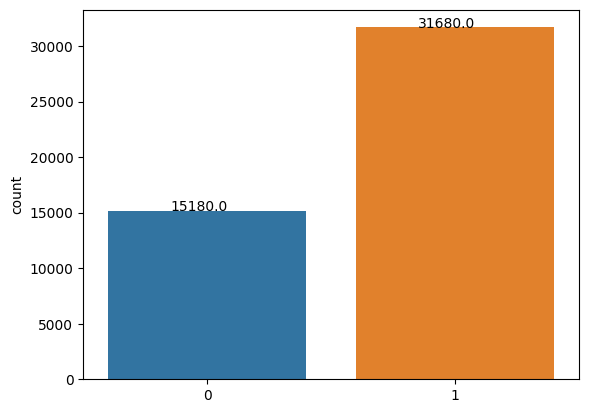

In [ ]:
ax = sns.countplot(x = y.reshape(y.shape[0]))
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))